# Ising GNN

## Imports

In [2]:
cd ../

/Users/rodrigo/Documents/Projects/BRAIN_ISING_GNN


/Users/rodrigo/miniconda3/envs/ising_gnn/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.getcwd()))

from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time
from scr.utils import import_data, compute_KNN_graph, create_batch,reconstruct_symmetric_matrix, read_motion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [5]:
import torch
import math

print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [6]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:


def create_graph(X_train, X_test, y_train, y_test, size=190 ,method={'knn' : 10}):
    
    train_data = []
    val_data = []

    # Creating train data in pyG DATA structure
    for i in range((X_train.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_train.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
        
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A

        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])

        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']


        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)
        
        train_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                               y=torch.tensor((y_train.iloc[i]))))

          
    # Creating test data in pyG DATA structure
    for i in range((X_test.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_test.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
                
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A   
        
        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])
            
        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']
          
        
        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)

        val_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                             y=torch.tensor((y_test.iloc[i]))))

    return train_data,val_data

## 2D Ising model simulation by MCMC

### $$E = -J\sum_{ij}^{N} \sigma_i \sigma_j; \quad P(\sigma_i flip | \Delta E > 0)= e^{-\beta \Delta E}; \quad P(\sigma_i flip | \Delta E < 0) = 1$$ $$; \quad \beta = \frac{1}{kT}$$

In [8]:
# Random initial state
def initial_state(L,string):
    if string == "aligned":
            state = np.full((L,L), 1,dtype=float)
    elif string == "random":
        state = 2 * np.random.randint(2, size=(L,L)) - 1
    else:
        return print("write aligned or random")
    return state

In [9]:
# Total energy calculation
@jit(nopython=True,fastmath=True,nogil=True)
def Total_Energy(config, J):
    L = len(config)
    total_energy = 0
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (J*total_energy/4) # we need to take of the repeated spins that we counted

In [10]:
# Monte Carlo algorithm 
@jit(nopython=True,fastmath=True,nogil=True)
def MC_met(config,beta,J):
    L = len(config)
    a = np.random.randint(0, L)
    b = np.random.randint(0, L)
    sigma =  config[a, b]
    neighbors = config[(a+1)%L, b] + config[a, (b+1)%L] + config[(a-1)%L, b] + config[a, (b-1)%L]
    del_E = 2*sigma*neighbors
    if del_E < 0:
        sigma *= -1
    elif np.random.rand() < np.exp(-del_E*beta):
        sigma *= -1
    config[a, b] = sigma
    return config

In [11]:
# Order Parameter
@jit(nopython=True,fastmath=True,parallel=True)
def mag(config):
    return np.sum(config)

In [12]:
@jit(nopython=True,fastmath=True,nogil=True)
def temporalseries(T,config,iterations,iterations_fluc,fluctuations,J,n):

    temporal_series = np.zeros((fluctuations,n,n))
    mag_data = np.zeros(fluctuations)
    ene_data = np.zeros(fluctuations)
    beta = 1/T
    
    #thermal equilibrium
    for i in range(iterations):
        #if i % 1000000 == 0:
            #print(i/iterations)
        config = MC_met(config,beta, J)
        
    for z in range(fluctuations):
        
        for i in range(iterations_fluc):
            config = MC_met(config,beta,J)

        temporal_series[z] = config
        ene_data[z] = Total_Energy(config, J) 
        mag_data[z] = mag(config)  
        
    return temporal_series, ene_data, mag_data

In [13]:
# Matrix containing all the system states
#@jit(nopython=True,fastmath=True,nogil=True)
def Matrix_X(Temps,config,iterations,J,n, block_size):
    
    fluctuations = 200

    X = np.zeros((len(Temps), int((n//block_size)**4)))#,int(((n)//block_size*block_size)**2)))

    for t in range(len(Temps)):
        print('Models ', t + 1, end="\r",flush=True)
        #if t%100 == 0:
            #print('Models ', t, end="\r",flush=True)
            #print('Temp ',Temps[t], end="\r",flush=True)

        model = temporalseries(Temps[t], config, iterations, n*n, fluctuations, J, n)
        avg_model = average_blocks(model, block_size)

        avg_model_df = pd.DataFrame(avg_model.reshape(fluctuations,avg_model.shape[1]*avg_model.shape[1]))
        #avg_model_df = avg_model_df#.diff(1).dropna()
        corr_matrix = (pd.DataFrame(avg_model_df).corr()).replace(1,0)#*10
        
        X[t,:] = corr_matrix.values.reshape(1,corr_matrix.shape[1]*corr_matrix.shape[1])
    

    return  X



In [14]:
def average_blocks(model, block_size):
    time_series_size = len(model[0][:,0,0]) 
    avg_model = np.zeros((time_series_size,int(len(model[0][1])/block_size),int(len(model[0][1])/block_size)))

    for t in range(time_series_size):
        for i in range(0,(len(model[0][0]) - block_size + 1),block_size):
            for j in range(0, (len(model[0][0]) - block_size + 1),block_size):
                l_0 = block_size
                avg_model[t][i//block_size, j//block_size] = np.mean(model[0][t][i:(i+l_0),j:(j+l_0)])
    return avg_model

In [15]:
@jit(nopython=True, fastmath=True, nogil=True)
def corr_net(temporal_series):
    
    steps = len(temporal_series)
    spins = len(temporal_series[0])**2
    
    temporal_series_linear = temporal_series.reshape((steps*spins ))
    
    corr_array = np.array([0.0])
    xi = np.zeros(steps)
    xj = np.zeros(steps)
    for i in range(spins):
        corr = np.zeros(spins - (i+1))
        for j in range(i+1,spins):
            for n in range(steps):
                xi[n] = temporal_series_linear[i + n*spins]
                xj[n] = temporal_series_linear[j + n*spins]

            diff_i = list()
            diff_j = list()
            for a in range(1, len(xi)):
                value_i = xi[a] - xi[a - 1]
                value_j = xj[a] - xj[a - 1]
                diff_i.append(value_i)
                diff_j.append(value_j)
            corr[j - (i+1)] = float(np.corrcoef(diff_i,diff_j)[0,1])

            #corr[j - (i+1)] = float(np.corrcoef(xi,xj)[0,1])
        corr_array = np.concatenate((corr_array,corr))
        
    return corr_array

## Experimental setup

#### fluctuations. increase iterations between time series points

In [16]:
n = 1000
config = initial_state(n,"random")
#fluctuations = 200
fluctuations = 1000
J = 1



model = temporalseries(2.3, config, ((n*n)*n)*30, 10*(n*n), fluctuations, J, n)
avg_model = average_blocks(model, 5)

avg_model_df = pd.DataFrame(avg_model.reshape(fluctuations,avg_model.shape[1]*avg_model.shape[1]))

In [17]:
model[0].shape

(1000, 1000, 1000)

In [18]:
avg_model.shape

(1000, 200, 200)

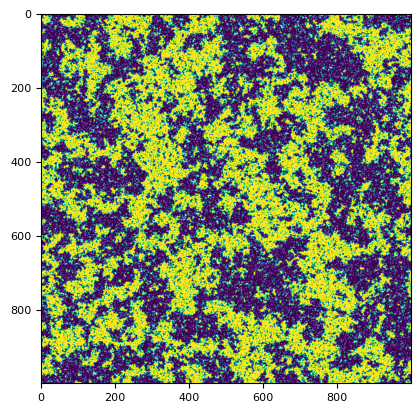

In [19]:
plt.imshow(model[0][0])

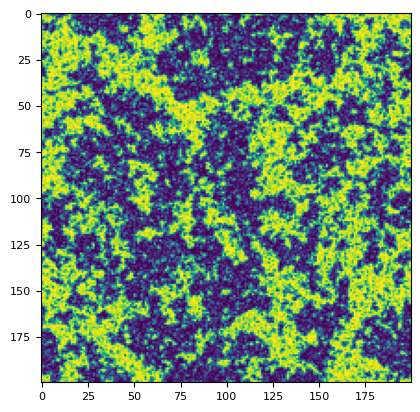

In [20]:
plt.imshow(avg_model[-1])

In [21]:
# import numpy as np
# import nilearn.plotting as plotting
# from nilearn import datasets, surface
# import nibabel as nib
# from scipy.spatial import cKDTree

# # Assume your 14x14 matrix is called `data_matrix`
# data_matrix = avg_model[-1]

# # Flatten and normalize data to match surface dimensions
# flattened_data = data_matrix.flatten()
# #normalized_data = (flattened_data - np.min(flattened_data)) / (np.max(flattened_data) - np.min(flattened_data))

# # Load a standard brain surface (fsaverage for example)
# fsaverage = datasets.fetch_surf_fsaverage('fsaverage4')

# # Load the actual surface mesh data from the file paths
# pial_left_mesh = surface.load_surf_mesh(fsaverage.pial_left)

# # Get the vertices and faces
# vertices = pial_left_mesh[0]  # Coordinates of the vertices

# # Define a grid of points where you want to project your matrix
# # For simplicity, assuming the matrix corresponds to a square region on the surface
# # You would need to determine this based on your specific data.
# x = np.linspace(vertices[:, 0].min(), vertices[:, 0].max(), 30)
# y = np.linspace(vertices[:, 1].min(), vertices[:, 1].max(), 30)
# xx, yy = np.meshgrid(x, y)
# grid_points = np.c_[xx.ravel(), yy.ravel()]

# # Find the nearest vertices on the cortical surface for each point in the grid
# tree = cKDTree(vertices[:, :2])  # Using only x and y coordinates for simplicity
# _, indices = tree.query(grid_points)

# # Initialize an array for the surface data
# surface_data = np.zeros(vertices.shape[0])

# # Assign matrix values to the nearest vertices
# for i, idx in enumerate(indices):
#     surface_data[idx] = flattened_data[i]

# # Viewing the data on the brain surface
# plotting.view_surf(fsaverage.infl_left, surface_data, cmap='viridis')

In [22]:
from sklearn.decomposition import FastICA
# Perform ICA
ica = FastICA(n_components=100,max_iter=1000, tol=1e-6, random_state=0)
S_ = ica.fit_transform(avg_model_df.T)
#S_ = ica.fit_transform(model[0].reshape(160000,2000))# Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# Plot results]
plt.figure()
ica_components = S_

<Figure size 640x480 with 0 Axes>

(0.0, 1048.95)

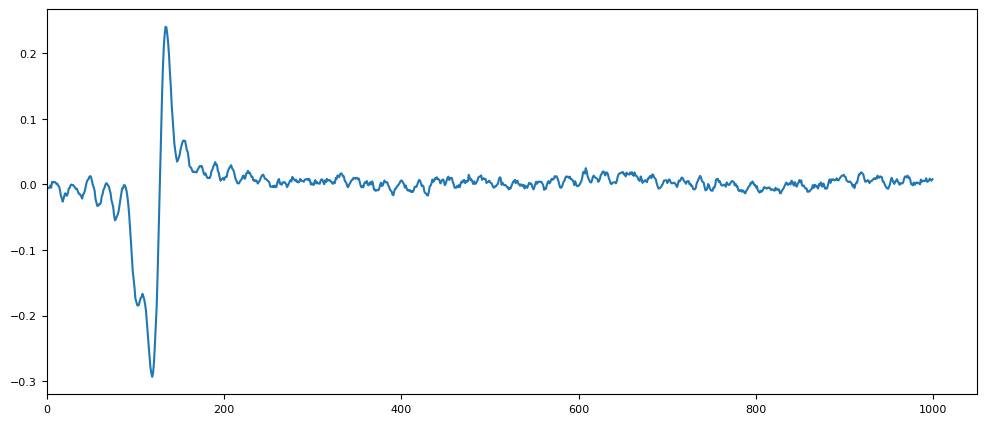

In [23]:
plt.figure(figsize=(12,5))
plt.plot(A_[:,80])
plt.xlim(0)

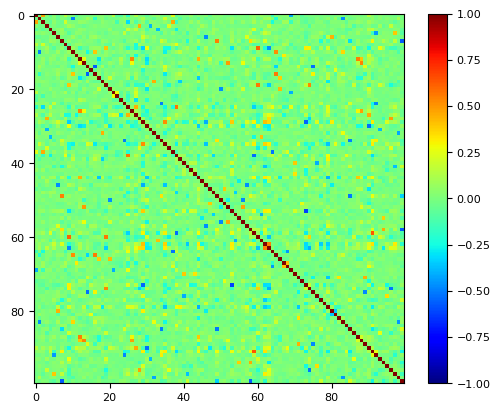

In [24]:
plt.imshow(pd.DataFrame(A_).corr(), cmap='jet', vmin=-1, vmax=1)
plt.colorbar()

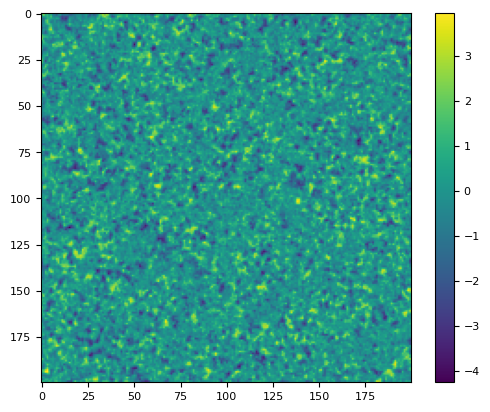

In [25]:
plt.imshow(ica_components[:,-3].reshape(200,200))
plt.colorbar()

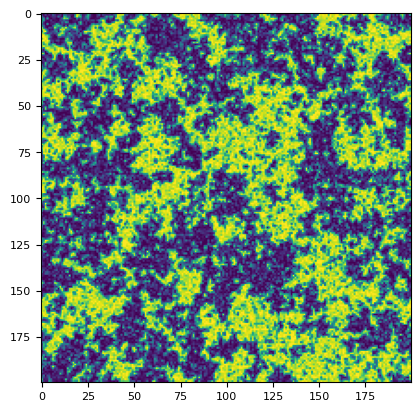

In [26]:
plt.imshow(avg_model[199])

In [ ]:
# import numpy as np

# # Reshape the arrays
# S_reshaped = S_.reshape(6, 160000)
# model_reshaped = model[0].reshape(160000, 200)

# # Perform matrix multiplication
# result = np.matmul(S_reshaped, model_reshaped[0])

# # Print the shape of the result to verify
# print("Shape of result:", result.shape)

In [14]:
J = 1     # J
n = 330    # Lattice size
iterations = ((n*n)*n)*30    # Iterations to thermal equilibrium
T_1 = np.linspace(1.6,2.21,400)
T_2 = np.linspace(2.21,2.35,800)
#T_3 = np.linspace(2.5,4,100)
Temps = np.hstack((T_1,T_2)).ravel()#,T_3 )).ravel()



In [ ]:
config = initial_state(n,"random")


X = Matrix_X(Temps, config,iterations,J,n,23)

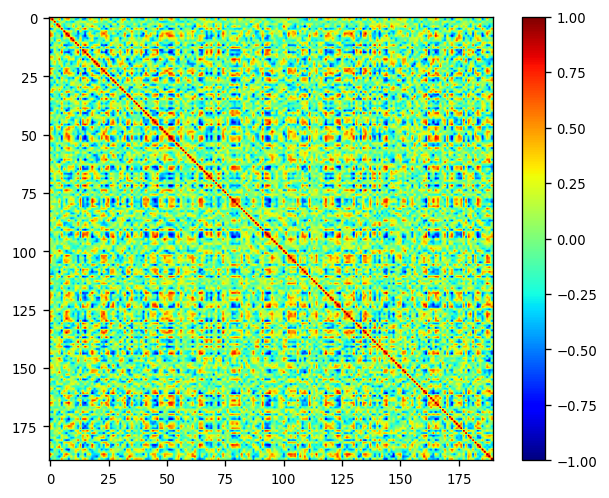

In [24]:
plt.figure(dpi=120)
plt.imshow(reconstruct_symmetric_matrix(190, X[732,:]), cmap='jet',vmin=-1, vmax=1)
plt.colorbar()

In [31]:
X

(1200, 17955)